#### This code reads a list of file locations and mask locations, load 8 MSI images+DeepView output+3 channel mask, stack them into one array, augment the array, produce one of each: shifted, rotated, flipped images, and save into .tif. 10 images saved (3 channel mask is merged into 1 channel).

#### Load packages

In [20]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
import scipy.misc
import os  
from operator import itemgetter
from os import listdir
from os.path import isfile, join
from skimage import data, color, img_as_float, io

#### Load parameters

In [28]:
shrink_N = 4 # down-sample size
batch_size= 1
save_loc= 'C:\Users\Valued Customer\Desktop\Lu\Github SMD\Data\\amputation_labels\\augmented'

#### Load file locations

In [12]:
loc=['E:\Baylor\Patient8\Diabetic_Ulcers\Study16\Ant.L.Foot\ImageColl_2',
        'E:\Baylor\Patient16\Diabetic_Ulcers\Study27\Ant.L.Foot\ImageColl_1',
        'E:\Baylor\Patient16\Diabetic_Ulcers\Study27\Ant.L.Leg\ImageColl_1',
        'E:\Baylor\Patient16\Diabetic_Ulcers\Study27\Ant.R.Foot\ImageColl_2',
        'E:\Baylor\Patient19\Diabetic_Ulcers\Study39\Ant.L.Foot\ImageColl_4']

#### Load mask

In [13]:
maskroot='C:\Users\Valued Customer\Desktop\Lu\Github SMD\Data\\amputation_labels\labels\\tif_files\\'
mask=['8_ALfoot_coll2.tif','p16_ALfoot_coll1.tif','p16_ALleg_coll1.tif',
         'p16_ARfoot_coll2.tif','p19_ALfoot_coll4.tif']

#### Define augmentation sub functions

In [6]:
def rotate():
    datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False,
                            rotation_range=90,dim_ordering='tf') # maximum rotation is 90 degrees
    return(datagen)

In [7]:
def shift(shift=0.2):
    datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False,
                            width_shift_range=shift, height_shift_range=shift)
    return(datagen)

In [9]:
def flip():
    datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False,
                            horizontal_flip=True, vertical_flip=True,dim_ordering='tf')
    return(datagen)

In [10]:
def aug(datagen, X, y, batch_size):
    
    # fit parameters from data
    datagen.fit(X)

    # configure batch size
    datagen.flow(X, y, batch_size)

    # retrieve one batch of images
    X_batch, y_batch = datagen.next()
    XX=np.array(X_batch[0],'uint8')
    return(XX)

In [31]:
def pop(XX, save_loc, maskloc, method):
    # this function separates raw images and mask, also merge mask from 3 channel to 1 channel, then save into .tif
    
    raw=XX[:,:,0:9] # first 9 images = 8MSI + DeepView
    
    M=XX[:,:,10:] # last 3 images are mask
    
    #### initialize class
    classid=3*np.ones((M.shape[0],M.shape[1]))   #### initialize to class 3

    #### merge mask into 1 channel
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if sum(M[i,j,:])!=0:
                classid[i,j]=np.argmax(M[i,j,:])   
                
    #### save 9 augmented images and mask
    # extract save name
    loc=maskloc.split(".tif")
    maskloc=loc[0]
    for i in range(9):
        plt.imshow(raw[:,:,i])
        plt.savefig(save_loc+"\\"+ maskloc + "_"+ method+ str(i) + ".tif")
        
    #### save mask
    plt.imshow(classid)
    plt.savefig(save_loc+"\\"+ maskloc + "mask" + ".tif")

#### Define load data function

In [29]:
def loaddata(dataloc,maskloc,shrink_N):
    
    os.chdir(dataloc)

    content_list = []

    for content in os.listdir("."): # "." means current directory
        content_list.append(content)
        
    #### down-sample  
    shrink = (slice(0, None, shrink_N), slice(0, None, shrink_N)) # down sample by N_shrink
        
    #### load 8 MSI images
    F=[img_as_float(data.load(dataloc+"//"+ content_list[i])[shrink]) for i in range(8)]
    
    #### collapse trailing dimensions
    F=np.squeeze(F) # dim = 8 * H * W

    #### load DeepView output
    D=data.load(dataloc+"//DeepViewOutput.tif")[shrink]
    D=color.rgb2gray(D); # convert DeepView output to 1 channel gray image
    D=np.reshape(D,(1,D.shape[0],D.shape[1]))
    
    #### merge 8 MSI and DeepView into 9 channel images
    F=np.append(F,D,axis=0) # dim(F) = 9 * H * W
    
    #### load mask
    M=data.load(maskroot+maskloc)[shrink]
    
    ### now mask has 4 dimensions, remove the last dimension
    M=M[:,:,0:3]
    
    #### swap axes
    F= np.swapaxes(F,0,2)
    F= np.swapaxes(F,0,1)
    
    #### merge mask into F, total 12 channels
    F= np.append(F,M,axis=2) 
    
    #### first 9 channel multiply by 256
    F[:,:,0:9]=256*F[:,:,0:9]
    
    return(F)

### Main function

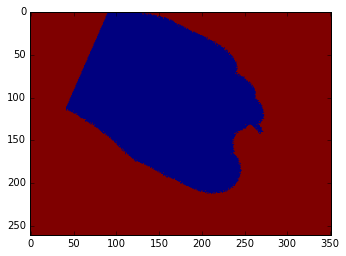

In [32]:
for dataloc, maskloc in zip(loc, mask):

    F= loaddata(dataloc,maskloc,shrink_N)
    
    #### prepare data for augmentation
    y =np.array([1],dtype=np.float32)
    X = F[np.newaxis,:]
    
    #### rotate
    datagen= rotate()
    XX_r=aug(datagen, X,y, batch_size)
    pop(XX_r, save_loc, maskloc, "rotate")
        
    #### shift
    datagen= shift()
    XX_s=aug(datagen, X,y, batch_size)
    pop(XX_s, save_loc, maskloc, "shift")
    
    #### flip
    datagen= flip()
    XX_f=aug(datagen, X,y, batch_size)
    pop(XX_f, save_loc, maskloc, "flip")